# DTSA 5511 Introduction to Deep Learning - WEEK 3
## CNN Cancer Detection Kaggle Mini-Project

### About the project

The dataset is located at https://www.kaggle.com/competitions/histopathologic-cancer-detection/data.
The goal is to 	identify correct labels of metastatic cancer by running a CNN model on 96 x 96 pixel with RGB channels images.
The dateset contains 220,025 images with labels 0 and 1. The final dataset will be splitted into train 
and test dataset (80% train and 20% test). The resulting model will be used to predict test dataset and measure accuracy. A final dataset will be sumbitted containing label predictions using the final model.

Due to the processing power required to run the models, the notebook was ran in colab.research.google.com. The data was retrieved using api key provided by kaggle.

### Exploratory Data Analysis (EDA) 

In [2]:
#load packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
from keras.layers import PReLU
from keras.initializers import Constant

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
#upload kaggle.json downloaded from kaggle account
from google.colab import files
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [11]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content"
"chmod 600 /content/kaggle.json"

!kaggle competitions download -c histopathologic-cancer-detection

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [10]:
#unzip downloded data
%%capture
!unzip "./histopathologic-cancer-detection.zip"

In [13]:
df = pd.read_csv('train_labels.csv')
print(df.shape)
df.head()

(220025, 2)


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


By looking at the distribution of labels in the dataset, there seems to be more non-cancerous images that cancerous. It is known that imbalanced dataset yields much lower accuracy and so we will balance the data.

In [14]:
df['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

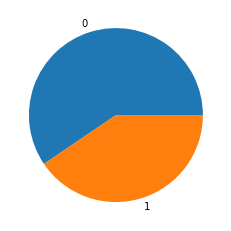

In [15]:
plt.pie(df['label'].value_counts(), labels=['0','1'])
plt.show()

In [16]:
#undersampling to balance

negative = df['label'] == 0
positive = df['label'] == 1
df_negative_undersample = df[negative].sample(n=positive.sum(), random_state=888)
df_new = pd.concat([df_negative_undersample, df[positive]])
df_new['label'].value_counts()

0    89117
1    89117
Name: label, dtype: int64

In [17]:
df_new.shape

(178234, 2)

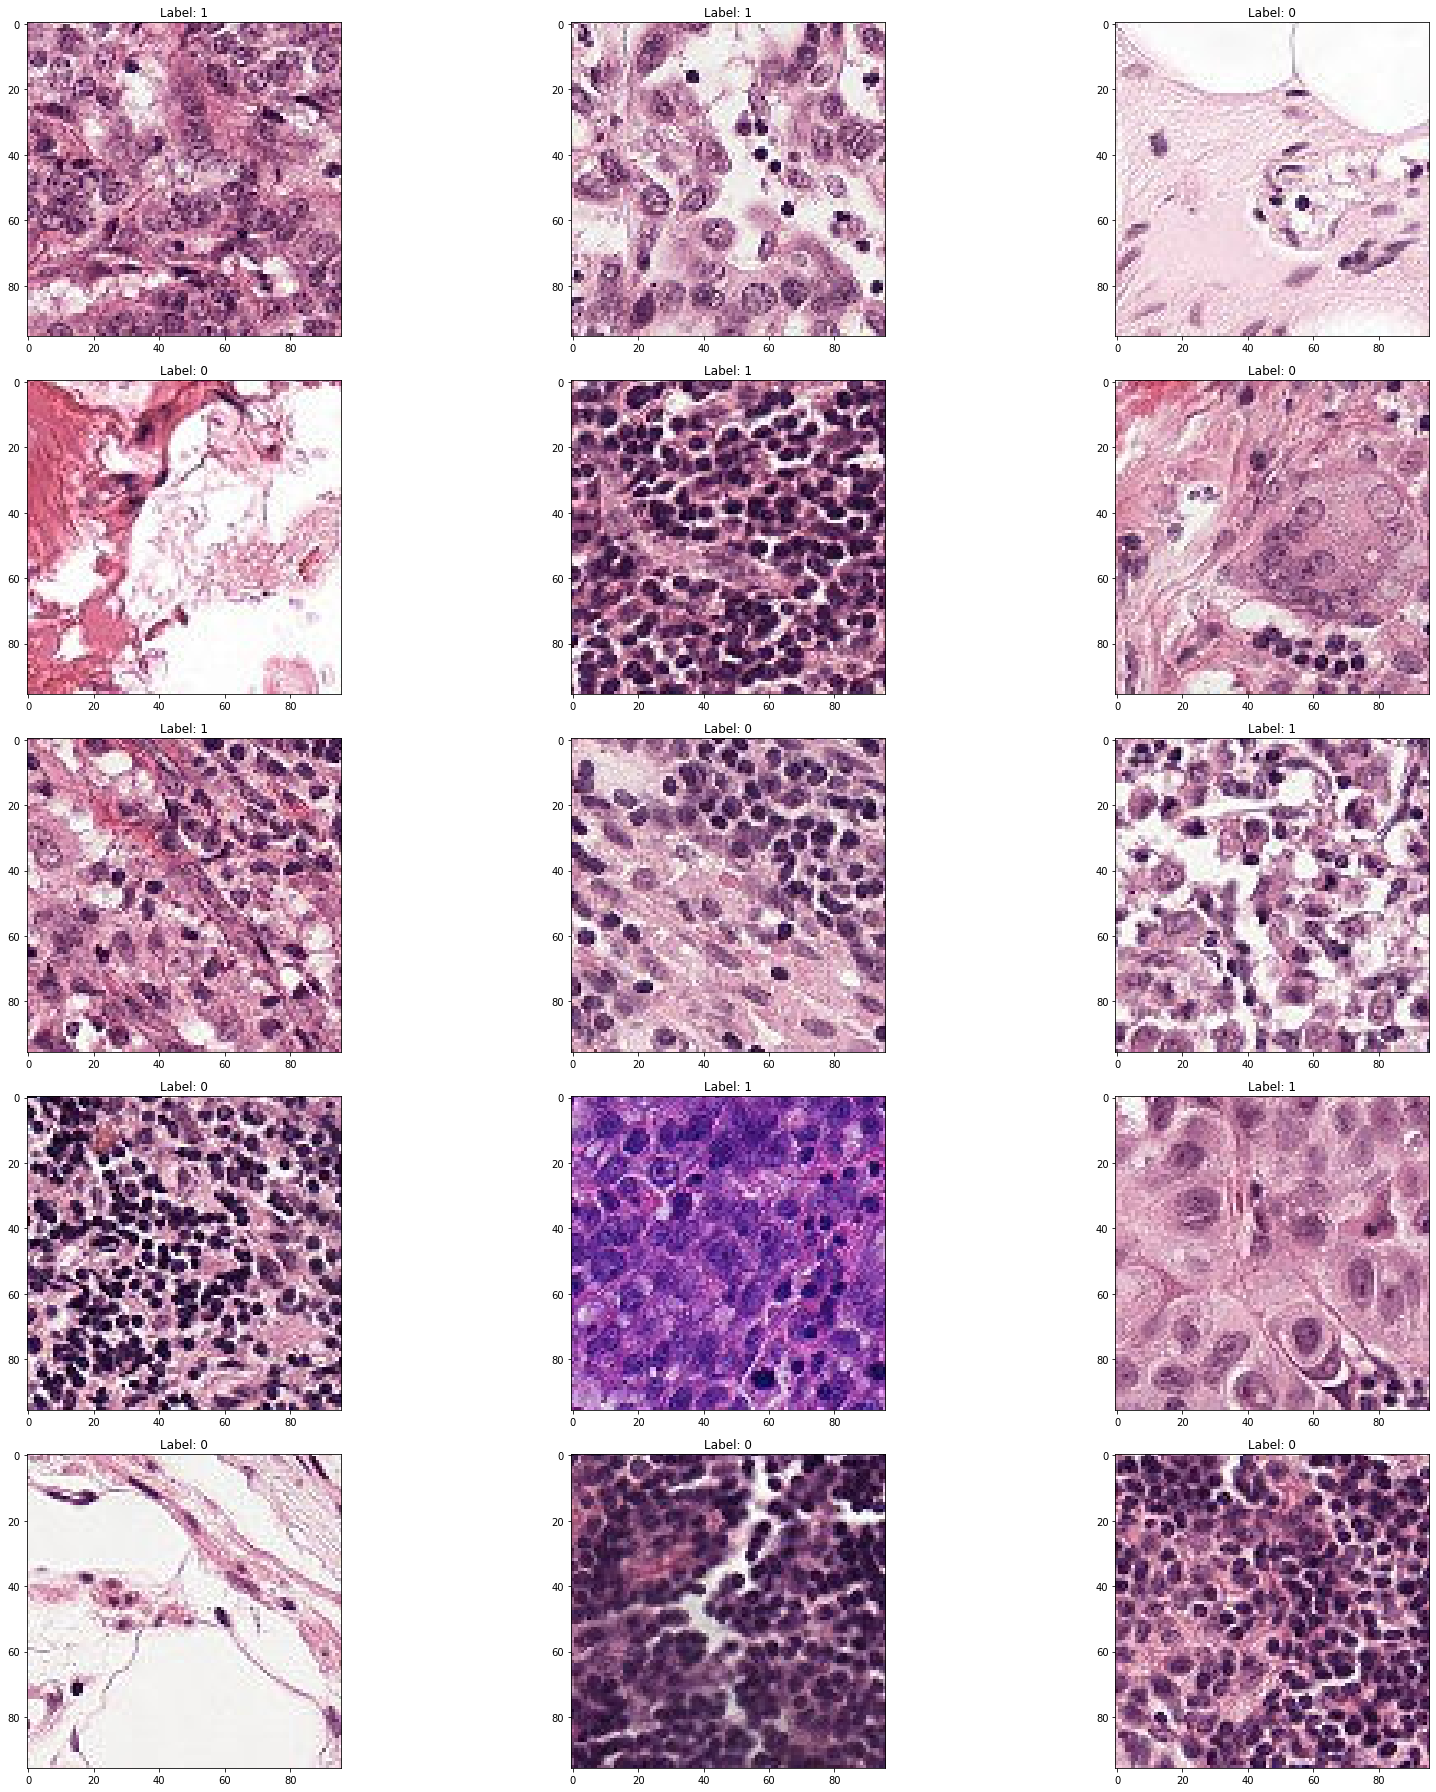

In [16]:
sample = np.random.choice(df.index,15)
fig, ax = plt.subplots(5, 3,figsize=(25,25))

for i in range(0, sample.shape[0]):
    ax = plt.subplot(5, 3, i + 1)
    img = mpimg.imread(f'/content/train/{df.iloc[sample[i],0]}.tif')
    ax.imshow(img)
    lab = df.iloc[sample[i], 1]
    ax.set_title('Label: %s'%lab)
    
plt.tight_layout()

### Model Architecture

The dataset will be split into train and test set (80/20). The model will use VGGNet architecture that utilizes blocks of convolutions [Conv-Conv-Max pool] set repeated n times. I will experiment by adding convolutions and changing the optimizer.

Model 1: activation function = relu, Adam Optimizer , 4 sets of 2 conv layers

Model 2: activation function = relu, Adam Optimizer, 3 sets of 5 conv layers

Model 3: activation function = relu, RMSprop Optimizer,  3 sets of 5 conv layers

In [18]:
train, test = train_test_split(df_new, stratify = df_new.label, test_size=0.2, random_state = 1234)
print(train.shape)
print(test.shape)

(142587, 2)
(35647, 2)


In [19]:
train['id'] = train['id'] + '.tif'
test['id'] = test['id'] + '.tif'
train['label'] = train['label'].astype(str)
test['label'] = test['label'].astype(str)

In [20]:
train_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_dataframe(dataframe = train,directory = f"/content/train/",
                x_col="id",y_col = "label",batch_size = 64,seed = 1234,shuffle = True,
                class_mode = "binary",target_size = (96,96))

test_generator = train_datagen.flow_from_dataframe(dataframe = test,directory = f"/content/train/",
                x_col = "id",y_col = "label",batch_size = 64,seed = 1234,shuffle = True,
                class_mode = "binary",target_size=(96,96))

Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


In [21]:
#Model 1 activation function = relu, Adam Optimizer

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
          
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Activation('relu')) 

model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [22]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 96, 96, 32)        896       
                                                                 
 activation_11 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 94, 94, 32)        9248      
                                                                 
 activation_12 (Activation)  (None, 94, 94, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 47, 47, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 47, 47, 32)       128       
 hNormalization)                                      

In [23]:
train_ss = train_generator.n//train_generator.batch_size
test_ss = test_generator.n//test_generator.batch_size

hist = model.fit(train_generator, steps_per_epoch = train_ss, validation_data = test_generator,
                              validation_steps = test_ss, epochs = 10, verbose = 1)

Epoch 1/10
2227/2227 [==============================] - 342s 147ms/step - loss: 0.3928 - accuracy: 0.8313 - val_loss: 0.3946 - val_accuracy: 0.8373
Epoch 2/10
2227/2227 [==============================] - 292s 131ms/step - loss: 0.2935 - accuracy: 0.8833 - val_loss: 0.5214 - val_accuracy: 0.7882
Epoch 3/10
2227/2227 [==============================] - 264s 119ms/step - loss: 0.2460 - accuracy: 0.9053 - val_loss: 0.5509 - val_accuracy: 0.8330
Epoch 4/10
2227/2227 [==============================] - 218s 98ms/step - loss: 0.2178 - accuracy: 0.9176 - val_loss: 0.3309 - val_accuracy: 0.8831
Epoch 5/10
2227/2227 [==============================] - 200s 90ms/step - loss: 0.1983 - accuracy: 0.9257 - val_loss: 0.5196 - val_accuracy: 0.8048
Epoch 6/10
2227/2227 [==============================] - 195s 88ms/step - loss: 0.1817 - accuracy: 0.9330 - val_loss: 0.6224 - val_accuracy: 0.7838
Epoch 7/10
2227/2227 [==============================] - 201s 90ms/step - loss: 0.1676 - accuracy: 0.9387 - val_loss

In [27]:
# model 2 added convolution layers

model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())

          
model1.add(Flatten())
model1.add(Dropout(0.25))
model1.add(Dense(512))
model1.add(Activation('relu'))

model1.add(Dropout(0.25))
model1.add(Dense(256))
model1.add(Activation('relu'))

model1.add(Dropout(0.25))
model1.add(Dense(64))
model1.add(Activation('relu')) 

model1.add(Dropout(0.25))
model1.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.Adam(0.001)
model1.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model1.summary()


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_67 (Conv2D)          (None, 96, 96, 32)        896       
                                                                 
 activation_70 (Activation)  (None, 96, 96, 32)        0         
                                                                 
 conv2d_68 (Conv2D)          (None, 94, 94, 32)        9248      
                                                                 
 activation_71 (Activation)  (None, 94, 94, 32)        0         
                                                                 
 conv2d_69 (Conv2D)          (None, 92, 92, 32)        9248      
                                                                 
 activation_72 (Activation)  (None, 92, 92, 32)        0         
                                                                 
 conv2d_70 (Conv2D)          (None, 90, 90, 32)       

In [28]:
hist1 = model1.fit(train_generator, steps_per_epoch = train_ss, validation_data = test_generator,
                              validation_steps = test_ss, epochs = 10, verbose = 1)

Epoch 1/10
2227/2227 [==============================] - 262s 116ms/step - loss: 0.4542 - accuracy: 0.8013 - val_loss: 0.4739 - val_accuracy: 0.7972
Epoch 2/10
2227/2227 [==============================] - 262s 118ms/step - loss: 0.3885 - accuracy: 0.8346 - val_loss: 0.7728 - val_accuracy: 0.7030
Epoch 3/10
2227/2227 [==============================] - 267s 120ms/step - loss: 0.3579 - accuracy: 0.8499 - val_loss: 1.2565 - val_accuracy: 0.5487
Epoch 4/10
2227/2227 [==============================] - 256s 115ms/step - loss: 0.3226 - accuracy: 0.8678 - val_loss: 0.4285 - val_accuracy: 0.8176
Epoch 5/10
2227/2227 [==============================] - 262s 118ms/step - loss: 0.2959 - accuracy: 0.8802 - val_loss: 0.6003 - val_accuracy: 0.7823
Epoch 6/10
2227/2227 [==============================] - 272s 122ms/step - loss: 0.2798 - accuracy: 0.8882 - val_loss: 0.4980 - val_accuracy: 0.7957
Epoch 7/10
2227/2227 [==============================] - 277s 124ms/step - loss: 0.2653 - accuracy: 0.8962 - val_

In [31]:
# model 3 RMSprop optimizer

model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

          
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(512))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(256))
model2.add(Activation('relu'))

model2.add(Dropout(0.25))
model2.add(Dense(64))
model2.add(Activation('relu')) 

model2.add(Dropout(0.25))
model2.add(Dense(1, activation='sigmoid'))
opt = tf.keras.optimizers.RMSprop(0.001)
model2.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

model2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_114 (Conv2D)         (None, 96, 96, 32)        896       
                                                                 
 activation_122 (Activation)  (None, 96, 96, 32)       0         
                                                                 
 conv2d_115 (Conv2D)         (None, 94, 94, 32)        9248      
                                                                 
 activation_123 (Activation)  (None, 94, 94, 32)       0         
                                                                 
 conv2d_116 (Conv2D)         (None, 92, 92, 32)        9248      
                                                                 
 activation_124 (Activation)  (None, 92, 92, 32)       0         
                                                                 
 conv2d_117 (Conv2D)         (None, 90, 90, 32)       

In [32]:
hist2 = model2.fit(train_generator, steps_per_epoch = train_ss, validation_data = test_generator,
                              validation_steps = test_ss, epochs = 10, verbose = 1)

Epoch 1/10
2227/2227 [==============================] - 304s 135ms/step - loss: 0.4695 - accuracy: 0.7943 - val_loss: 0.8902 - val_accuracy: 0.5110
Epoch 2/10
2227/2227 [==============================] - 312s 140ms/step - loss: 0.4202 - accuracy: 0.8281 - val_loss: 0.6468 - val_accuracy: 0.7914
Epoch 3/10
2227/2227 [==============================] - 335s 150ms/step - loss: 0.3946 - accuracy: 0.8402 - val_loss: 0.5038 - val_accuracy: 0.7911
Epoch 4/10
2227/2227 [==============================] - 333s 149ms/step - loss: 0.3717 - accuracy: 0.8503 - val_loss: 0.4955 - val_accuracy: 0.7870
Epoch 5/10
2227/2227 [==============================] - 299s 134ms/step - loss: 0.3563 - accuracy: 0.8595 - val_loss: 0.5529 - val_accuracy: 0.7932
Epoch 6/10
2227/2227 [==============================] - 304s 137ms/step - loss: 0.3418 - accuracy: 0.8655 - val_loss: 0.3966 - val_accuracy: 0.8247
Epoch 7/10
2227/2227 [==============================] - 301s 135ms/step - loss: 0.3323 - accuracy: 0.8711 - val_

### Results and Analysis

Now, let's look at the accuracy for each epoch for train vs test sets.

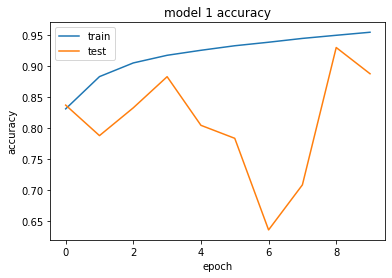

In [47]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model 1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

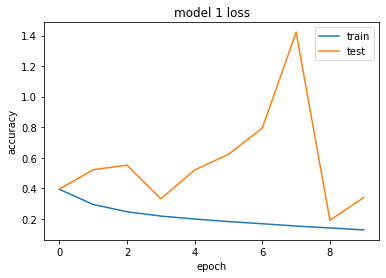

In [48]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model 1 loss')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

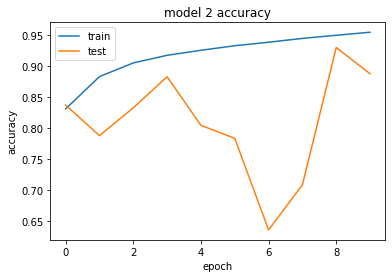

In [50]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model 2 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

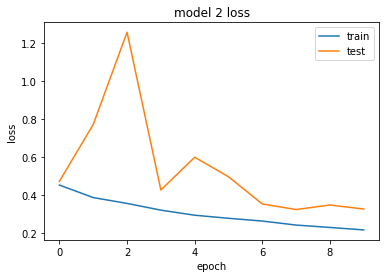

In [49]:
plt.plot(hist1.history['loss'])
plt.plot(hist1.history['val_loss'])
plt.title('model 2 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

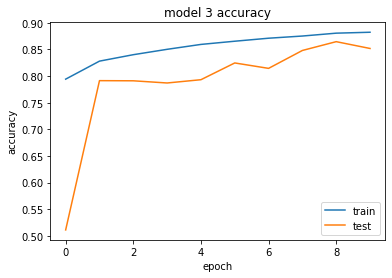

In [51]:
plt.plot(hist2.history['accuracy'])
plt.plot(hist2.history['val_accuracy'])
plt.title('model 3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

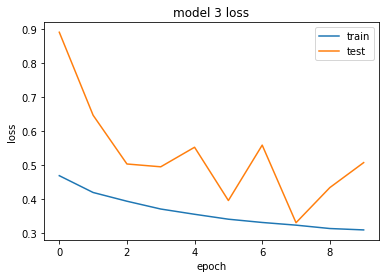

In [52]:
plt.plot(hist2.history['loss'])
plt.plot(hist2.history['val_loss'])
plt.title('model 3 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

### Conclusion

While the first 2 models reached faster to much higher accuracy, there were some fluctuations at 6th epoch as well as the loss. Looking at the last model with RMS prop, it has steady increase as well as the decrease in loss but has much higher processing time. For these reasons, I will choose the first model as the best model based on accuracy and processing times. For future improvements, we can increase the epoch to see more behavior.

In [62]:
df_test = pd.DataFrame(os.listdir('/content/test/'))
df_test.columns = ['id']
df_test.head()

,id
0,a2aeee005e8b71bcf26cf2ddbf2f4fa667f858be.tif
1,f9b419ab9494ff399ceaccb5964b2f2cbe575e91.tif
2,ea5c8559b6cb08c6e41d9cc2c56dd3253b035423.tif
3,01d0bc282fc3dd74b8c648cf194249fcf2a36a90.tif
4,448e6570666405e89ebebf18b4f6f1dc7a2211d5.tif


In [64]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_dataframe(dataframe = df_test, directory = f"/content/test/",
                x_col = "id",seed = 1234 , shuffle = False,
                class_mode = None, target_size = (96,96))

Found 57458 validated image filenames.


In [69]:
test_df_ss = test_generator.n/2

preds = model.predict(test_generator)

In [70]:
pred = []

for i in preds:
    if i >= 0.5:
        pred.append(1)
    else:
        pred.append(0)

In [86]:
df_test['label'] = pred
df_final = df_test.copy()
df_final['id'] = df_final['id'].str[:-4]
df_final.head()

,id,label
0,a2aeee005e8b71bcf26cf2ddbf2f4fa667f858be,0
1,f9b419ab9494ff399ceaccb5964b2f2cbe575e91,1
2,ea5c8559b6cb08c6e41d9cc2c56dd3253b035423,0
3,01d0bc282fc3dd74b8c648cf194249fcf2a36a90,0
4,448e6570666405e89ebebf18b4f6f1dc7a2211d5,0


In [85]:
df_final.to_csv('submission.csv',index=False)

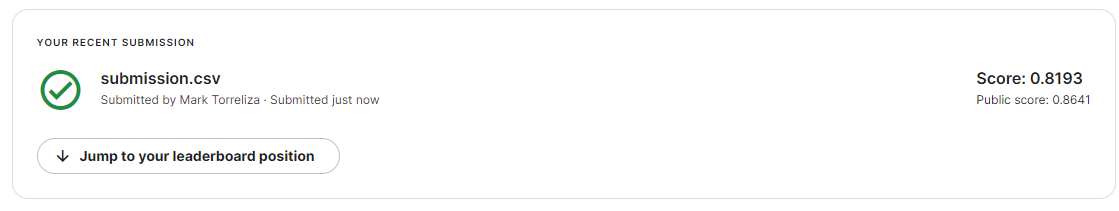